# Shapes of non-Gaussianities

<div class="alert alert-block alert-info"> In this notebook, you will learn how to produce the usual 3D shape figures describing the bispectrum shape. We will also (re-)discover the cosmological low-speed collider signal, which takes the form of a resonance in mildly-soft kinematic configurations. </div>

In [1]:
# Import the standard Python packages
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For Latex-style labels
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r"\usepackage{bm}")

# Import CosmoFlow modules (they must be located in the same parent folder as this notebook)
from Parameters import parameters
from Theory import theory
from Solver import solver

In [2]:
# Define the numerical i\epsilon prescription
def adiabatic(N_load, DeltaN, N_exit):
    return (np.tanh((N_load - N_exit + DeltaN - 0.5)/0.1) + 1)/2

<div class="alert alert-block alert-info"> <strong>Task:</strong> Understand the following script and execute it. </div>

In [ ]:
def Shape(X, Y, cs, m, rho):
    n = 10000 # Number of points for the parameter evaluation
    N_load = np.linspace(-15, 20, n) # Time grid array in e-folds for the parameters
    DeltaN = 4.5 # Number of e-folds before horizon crossing
    
    k = 1 # Mode corresponding to N = 0 horizon exit
    k1, k2, k3 = X*k, Y*k, k # Kinematic configuration for 3-pt function
    N_exit = np.log(np.min([k1, k2, k3])) # Horizon exit for a mode
    
    # Theory 
    H_load = np.ones(n) # Hubble scale
    cs_load = cs * np.ones(n) # Speed of sound for phi
    m_load = m * np.ones(n) # Mass of Psi
    rho_load = rho * np.ones(n) * adiabatic(N_load, DeltaN, N_exit) # Linear mixing strength
    g_load = 1 * np.ones(n) * adiabatic(N_load, DeltaN, N_exit) # Cubic coupling
    
    # Load the parameters and define continuous functions
    param = parameters(N_load, H_load, cs_load, m_load, rho_load, g_load) # Load the class parameters
    interpolated = param.output() # Define list with continuous parameters
    
    # Numerical parameters
    Nspan = np.linspace(-10, 20, 1000) # Time span in e-folds for the numerical integration
    Nfield = 2 # Number of fields
    Rtol, Atol = 1e-3, 1e-20 # Relative and absolute tolerance of the integrator
    Ni, Nf = N_exit - DeltaN, 20 # Sets initial and final time for integration
    N = np.linspace(Ni, Nf, 1000) # Define the time array for output correlators

    # Initialise the integrator
    theo = theory(N = Nspan, Nfield = Nfield, interpolated = interpolated)
    
    s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
    f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)
    
    three_pt = f[6][0, 0, 0][-1]
    return (k1*k2*k3)**2 * three_pt # Equivalent to shape function

<div class="alert alert-block alert-info"> <strong>Task:</strong> Execute the following script. Caution, it can take a few minutes. </div>

In [ ]:
from joblib import Parallel, delayed # Needed for parallelisation
import time # Record the running time

n = 20

# Define the triangle
left_point = np.array([0.5, 0.5])
right_point = np.array([1, 1])
top_point = np.array([0.02, 1]) # Specify the softer configuration
left_m = (top_point[-1] - left_point[-1]) / (top_point[0] - left_point[0])
left_c = 1
right_m = (right_point[-1] - left_point[-1]) / (right_point[0] - left_point[0])
right_c = left_point[0] - right_m*left_point[0]
X_left = np.linspace(left_point[0], top_point[0], n)
Y_left = left_m * X_left + left_c
X_right = np.linspace(left_point[0], right_point[-1], n)
Y_right = right_m * X_right + right_c
LR_X = np.hstack([X_left[:, None], X_right[:, None]])
XX = np.meshgrid(np.linspace(LR_X[:, 0], LR_X[:, 1], n))[0].reshape(n, n) # k1/k3
YY = np.meshgrid([Y_left*np.ones(n)]*n)[0].reshape(n, n) # k2/k3

def process(i):
    S = []
    for j in range(n):
        S.append(Shape(X = XX[i, j], Y = YY[i, j], cs = 0.05, m = 2, rho = 0.1)  )
    return S

start_time = time.time() # Start recording runtime
ZZ = Parallel(n_jobs = 6)(delayed(process)(i) for i in range(n)) # n_jobs is the number of cores
print("--- %s seconds ---" % (time.time() - start_time)) # Print runtime

ZZ = np.nan_to_num(ZZ)

# Save file
np.save("k1k3.npy", XX)
np.save("k2k3.npy", YY)
np.save("Shape_cs005m2rho01.npy", ZZ)

<div class="alert alert-block alert-info"> <strong>Task:</strong> Execute the following script to show the result. 
<ul>
    <li>Does the shape resembles any standard shape?</li>
  </ul>
 </div>

In [ ]:
XX = np.load("k1k3.npy")
YY = np.load("k2k3.npy")
ZZ = np.load("Shape_cs005m2rho01.npy")

import matplotlib as mpl
plt.style.use('default')
plt.rc('text.latex', preamble=r"\usepackage{bm}")
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
mpl.rc('axes', edgecolor = "w", labelcolor = "k")

fig = plt.figure(figsize = (6, 4))
ax = plt.axes(projection = '3d')
ax.grid(False)
ax.view_init(30, 230)

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

edges_kw = dict(color = "k", linewidth = 0.5, zorder = 1e3)

ax.set_xlim(0, 1)
ax.set_ylim(0.5, 1)
ax.set_zlim(0.4, 2.1)

ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0.5, 1])
ax.set_zticks([1, 2])


ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$k_1/k_3$", fontsize = 12)
ax.set_ylabel("$k_2/k_3$", fontsize = 12)
ax.set_title(r"$(k_1k_2k_3)^2\,\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2} \varphi_{\bm{k}_3}\rangle'$", fontsize = 12)

# Plot Shape
c_m = mpl.cm.coolwarm
ax.plot_surface(XX, YY, ZZ/ZZ[-1, -1], rstride = 1, cstride = 1, cmap = c_m, edgecolor = "None") # 3D shape
cset = ax.contourf(XX, YY, ZZ/ZZ[-1, -1], zdir = "z", offset = 0.4, levels = 10, cmap = c_m, alpha = 0.4) # Projection


<div class="alert alert-block alert-info"> <strong>Task:</strong> understand the following script and execute it. </div>

In [9]:
def Soft_Limit(kappa, cs, m, rho):
    n = 10000 # Number of points for the parameter evaluation
    N_load = np.linspace(-15, 20, n) # Time grid array in e-folds for the parameters
    DeltaN = 5 # Number of e-folds before horizon crossing
    
    k = 1 # Mode corresponding to N = 0 horizon exit
    k1, k2, k3 = k/kappa, k/kappa, k # Kinematic configuration for 3-pt function
    N_exit = 0 # Horizon exit for a mode
    
    # Theory 
    H_load = np.ones(n) # Hubble scale
    cs_load = cs * np.ones(n) # Speed of sound for phi
    m_load = m * np.ones(n) # Mass of Psi
    rho_load = rho * np.ones(n) * adiabatic(N_load, DeltaN, N_exit) # Linear mixing strength
    g_load = 1 * np.ones(n) * adiabatic(N_load, DeltaN, N_exit)
    
    # Load the parameters and define continuous functions
    param = parameters(N_load, H_load, cs_load, m_load, rho_load, g_load) # Load the class parameters
    interpolated = param.output() # Define list with continuous parameters

    # Numerical parameters
    Nspan = np.linspace(-10, 20, 1000) # Time span in e-folds for the numerical integration
    Nfield = 2 # Number of fields
    Rtol, Atol = 1e-3, 1e-20 # Relative and absolute tolerance of the integrator
    Ni, Nf = N_exit - DeltaN, 10 # Sets initial and final time for integration
    N = np.linspace(Ni, Nf, 1000) # Define the time array for output correlators

    # Initialise the integrator
    theo = theory(N = Nspan, Nfield = Nfield, interpolated = interpolated)
    
    s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
    f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)
    
    three_pt = f[6][0, 0, 0][-1]
    return (k1*k2*k3)**2 * three_pt # Equivalent to shape function

<div class="alert alert-block alert-info"> <strong>Task:</strong> Execute the following script for cs=1 and for cs=0.05, with fixed m/H=2 and rho/H=0.1. Caution, this might take a few minutes.
<ul>
    <li>Plot the result. Comment.</li>
    <li>What do you notice in the squeezed limit for cs=1?</li>
  </ul>
  </div>

In [12]:
from joblib import Parallel, delayed # Needed for parallelisation
import time # Record the running time

cs, m, rho = 1, 2, 0.1

n_pt = 20
kappa = np.logspace(-2, 0, n_pt) # k1/k3 with k1=k2

def process(i):
    return Soft_Limit(kappa = kappa[i], cs = cs, m = m, rho = rho)

start_time = time.time() # Start recording runtime
X = Parallel(n_jobs = 6)(delayed(process)(i) for i in range(n_pt)) # n_jobs is the number of cores
print("--- %s seconds ---" % (time.time() - start_time)) # Print runtime

# Save files
np.save("S_cs1.npy", X)
np.save("kappa.npy", kappa)

--- 178.109521150589 seconds ---


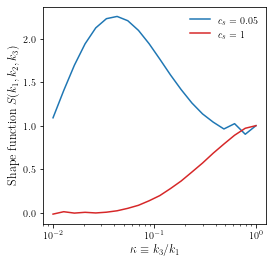

In [16]:
fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot()

kappa = np.load("kappa.npy")
S_cs005 = np.load("S_cs005.npy")
S_cs1 = np.load("S_cs1.npy")

ax.semilogx(kappa, S_cs005/S_cs005[-1], color = "C0", label = "$c_s = 0.05$")
ax.semilogx(kappa, S_cs1/S_cs1[-1], color = "C3", label = "$c_s = 1$")

ax.set_xlabel(r"$\kappa \equiv k_3/k_1$", fontsize = 12)
ax.set_ylabel(r"Shape function $S(k_1, k_2, k_3)$", fontsize = 12)
ax.legend(frameon = False)
